# Phase 2: Type-based Service Identification (Grouping by Same Type Classes)

In [3]:
version = "v_imen" # All options: v_imen, v_team
system = "pos" # All options: jforum, cargotracker, petclinic, pos
# Pas d'influence du modèle d'embeddings puisqu'on n'utilise que les distances statiques
model_type = "codebert" # All options: ft_codebert, word2vec, albert, codebert, roberta, bert

## 1.1 Create class graph

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import load_class_code_from_directory, load_data_from_csv, print_communities, save_communities_to_csv
from distances import compute_semantic_distances_for_class_pairs
from visualization import visualize_heatmap
from normalization import filter_and_normalize_distances

ModuleNotFoundError: No module named 'pandas'

In [ ]:
def load_data(system, version, model_type):
    """Load class code, class names, labels, and embeddings."""
    class_code = load_class_code_from_directory(system)
    class_names, class_labels, class_embeddings = load_data_from_csv(f"generated_data/embedding/{version}_{system}_{model_type}_embeddings.csv")
    return class_code, dict(zip(class_names, class_labels)), dict(zip(class_names, class_embeddings))

def load_call_graph(system):
    """Load the call graph."""
    file_path = f"./generated_data/graph/call/{system}_call_graph.csv"
    call_graph = pd.read_csv(
        file_path,
        delimiter=';',
        header=None,
        names=['class1', 'class2', 'static_distance']
    )
    return call_graph

def merge_dataframes(static_df, semantic_df):
    """Merge structural and semantic dataframes."""
    merged_df = static_df.merge(semantic_df, on=['class1', 'class2'], how='outer')
    return merged_df.fillna({'static_distance': 0, 'semantic_distance': 0})

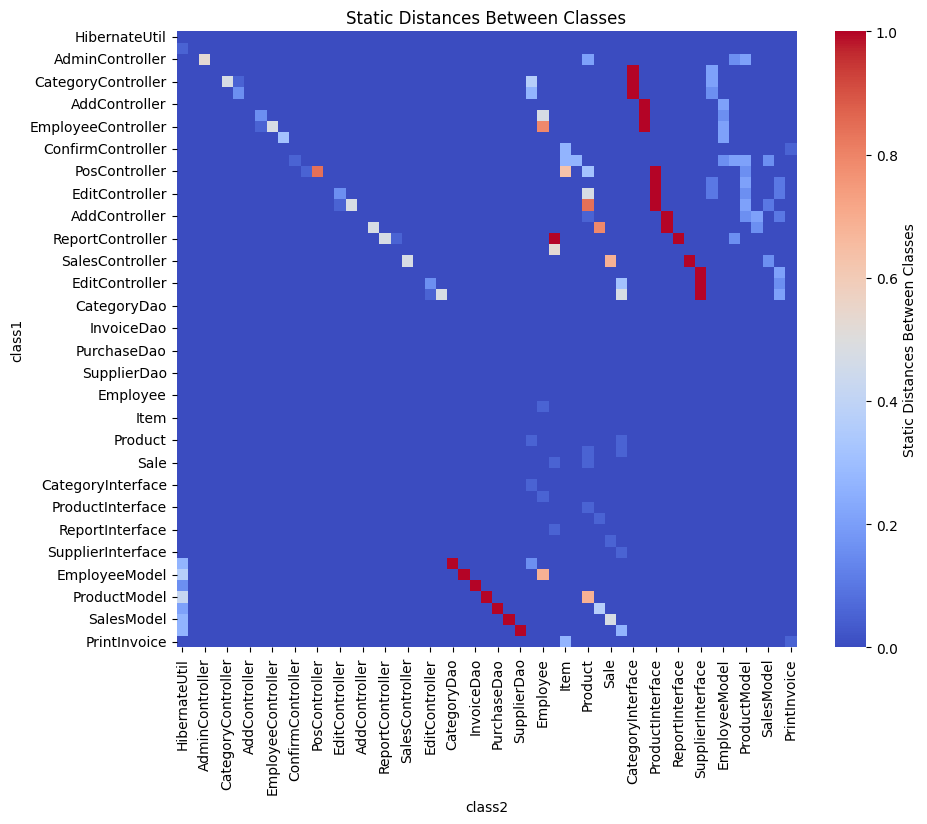

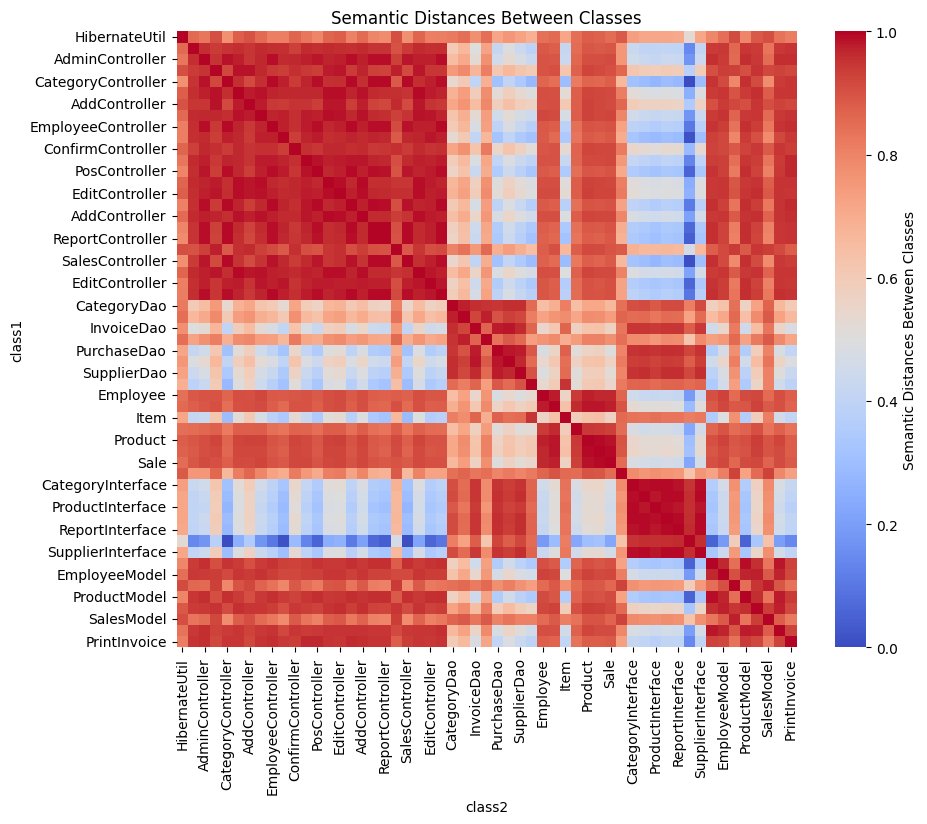

In [ ]:
# Main execution
_, class_labels_dict, class_embeddings_dict = load_data(system, version, model_type)
static_df = load_call_graph(system)

if system == 'cargotracker': # temporary fix
    # Replace 'org.eclipse' with 'net.java' in both class1 and class2 columns
    static_df['class1'] = static_df['class1'].str.replace('org.eclipse', 'net.java', regex=False)
    static_df['class2'] = static_df['class2'].str.replace('org.eclipse', 'net.java', regex=False)

semantic_df = compute_semantic_distances_for_class_pairs(class_embeddings_dict)
static_df = filter_and_normalize_distances(static_df, class_labels_dict)
semantic_df = filter_and_normalize_distances(semantic_df, class_labels_dict)
class_graph = merge_dataframes(static_df, semantic_df)

# Visualizations
visualize_heatmap(class_graph, 'static_distance', "Static Distances Between Classes")
visualize_heatmap(class_graph, 'semantic_distance', "Semantic Distances Between Classes")

# Save to CSV
filename = f"./generated_data/graph/class/{version}_{system}_class_graph.csv"
class_graph.to_csv(filename, index=False)

## 1.2 Community detection

In [ ]:
import networkx as nx
from cdlib import algorithms
from karateclub import EdMot
import numpy as np

ModuleNotFoundError: No module named 'karateclub'

In [ ]:
class CommunityDetection:
    
    def __init__(self, graph, class_labels_dict, optimize_hyperparameters_flag=False):
        self.graph = graph.copy()  # Create a copy of the graph to avoid modifying the original
        self.graph.remove_edges_from(nx.selfloop_edges(self.graph))  # Remove self-loops
        self.class_labels_dict = class_labels_dict
        self.optimize_hyperparameters_flag = optimize_hyperparameters_flag
        self.best_params = {}

    def get_subgraph_reindexed(self, label_type):
        """Get a subgraph based on label type and reindex its nodes."""
        label_mapping = {'Application': 0, 'Utility': 1, 'Entity': 2}
        classes = [class_name for class_name, label in self.class_labels_dict.items() if label == label_mapping.get(label_type)]
        subgraph = self.graph.subgraph(classes)
        # self.visualize_subgraph(subgraph, label_type)
        mapping = {node: i for i, node in enumerate(subgraph.nodes())}
        return nx.relabel_nodes(subgraph, mapping), {i: node for node, i in mapping.items()}

    def visualize_subgraph(self, subgraph, label_type):
        """Visualize the subgraph."""
        labels = {node: node.split('.')[-1] for node in subgraph.nodes()}
        
        # Determine edge weights for thickness, and scale for visibility
        min_thickness = 0.5  # minimum thickness for edges
        max_thickness = 5.0  # maximum thickness for edges
        edge_weights = [subgraph[u][v]['static_distance'] for u, v in subgraph.edges()]

        if len(edge_weights) == 1:
            scaled_weights = [min_thickness + (max_thickness - min_thickness) / 2]  # mid-thickness for a single edge
        else:
            scaled_weights = [min_thickness + (w - min(edge_weights)) * (max_thickness - min_thickness) / 
                            (max(edge_weights) - min(edge_weights)) for w in edge_weights]
        
        # Use spring_layout for node positioning
        pos = nx.spring_layout(subgraph, scale=100, weight='static_distance', iterations=100) # change scale to spread nodes more
        
        plt.figure(figsize=(8, 8))
        nx.draw(subgraph, pos=pos, with_labels=True, labels=labels, 
                node_size=500, node_color="lightblue", font_size=8, 
                font_weight="bold", width=scaled_weights, edge_color="grey")
        
        plt.title(f"{label_type} Classes Subgraph")
        plt.show()

    def remove_duplicate_single_node_communities(self, communities):
        """Remove duplicated single-node communities."""
        # Get the single-node communities
        single_node_communities = [community for community in communities if len(community) == 1]
        
        # Convert to sets for easy comparison and remove duplicates
        unique_single_node_communities = set(tuple(community) for community in single_node_communities)
        
        # Remove all single-node communities from the original list
        communities = [community for community in communities if len(community) != 1]
        
        # Add back the unique single-node communities
        communities.extend([list(community) for community in unique_single_node_communities])
        
        return communities

    def _algorithm_edmot(self, subgraph_reindexed):
        """Compute communities using the EdMot algorithm."""
        edmot = EdMot()
        edmot.fit(subgraph_reindexed)
        memberships = edmot.get_memberships()
        unique_communities = set(memberships.values())
        return [list({node for node, community_id in memberships.items() if community_id == c}) for c in unique_communities]

    def detect_communities(self, label_type, algorithm):
        """Perform community detection based on a specified algorithm."""
        subgraph_reindexed, inverse_mapping = self.get_subgraph_reindexed(label_type)

        # If hyperparameter optimization flag is set, optimize parameters
        if self.optimize_hyperparameters_flag:
            self.best_params = self.optimize_hyperparameters(subgraph_reindexed, algorithm)
            
        ALGORITHMS = {
            'Louvain': lambda: algorithms.louvain(subgraph_reindexed, weight='weight', resolution=self.best_params.get('resolution', 0.5)).communities,
            'Infomap': lambda: algorithms.infomap(subgraph_reindexed).communities,
            'LabelPropagation': lambda: algorithms.label_propagation(subgraph_reindexed).communities,
            'GirvanNewman': lambda: algorithms.girvan_newman(subgraph_reindexed, level=self.best_params.get('level', 1)).communities,
            'FastGreedy': lambda: algorithms.greedy_modularity(subgraph_reindexed).communities,
            'EdMot': lambda: self._algorithm_edmot(subgraph_reindexed)
        }
            
        if len(subgraph_reindexed.nodes()) < 4:
            communities_reindexed = list(nx.community.label_propagation_communities(subgraph_reindexed))
        else:
            # If the graph is disconnected and the algorithm is Infomap or FastGreedy, skip the algorithm.
            if (not nx.is_connected(subgraph_reindexed) and (algorithm == 'Infomap' or algorithm == 'FastGreedy')):
                print(f"Graph is disconnected. Skipping {algorithm}.")
                return [[inverse_mapping[node]] for node in subgraph_reindexed.nodes()]  # Treat each node as its own community
            else:
                communities_reindexed = ALGORITHMS.get(algorithm, lambda: print(f"Error: The algorithm '{algorithm}' is not supported. Supported algorithms are: {', '.join(ALGORITHMS.keys())}."))()

        # Handle isolated nodes:
        # Create separate communities for each of them
        isolated_nodes = [node for node in subgraph_reindexed.nodes() if subgraph_reindexed.degree(node) == 0]
        for node in isolated_nodes:
            communities_reindexed.append([node])

        communities = [[inverse_mapping[node] for node in community] for community in communities_reindexed]
        
        # Remove duplicated single-node communities
        communities = self.remove_duplicate_single_node_communities(communities)

        return communities

    def optimize_hyperparameters(self, label_type, subgraph_reindexed, algorithm):
        best_params = {}
        best_modularity = -1  # initialize with a low value

        PARAM_RANGES = {
            'Louvain': (np.arange(0.1, 2.0, 0.2), 'resolution'),
            'GirvanNewman': (range(1, 10), 'level')
        }

        if algorithm in PARAM_RANGES:
            param_values, param_name = PARAM_RANGES[algorithm]

            for value in param_values:
                # Make sure the subgraph is connected before computing modularity
                if not nx.is_connected(subgraph_reindexed):
                    continue
                
                communities = self.detect_communities(label_type, algorithm, **{param_name: value})
                modularity_value = nx.community.modularity(subgraph_reindexed, communities)

                if modularity_value > best_modularity:
                    best_modularity = modularity_value
                    best_params[param_name] = value
        else:
            print(f"Parameter optimization not supported for {algorithm}")
        return best_params

## 1.3 Community fine-tuning

In [ ]:
def fine_tune_cluster(service, services, distance_map):
    score_service = {i: 0 for i in range(len(services))}
    
    for other_service, distance in distance_map.get(service, {}).items():
        for i, s in enumerate(services):
            if other_service in s:
                score_service[i] += distance
    
    max_score = max(score_service.values())
    if max_score > 0:
        max_indices = [i for i, x in enumerate(score_service.values()) if x == max_score]
        if len(max_indices) == 1:
            services[max_indices[0]].append(service)
            services = [s for s in services if s != [service]]

    return services

def fine_tune_all_services(services_list, distances):
    distance_map = {s1: {s2: d} for s1, s2, d in distances}
    
    for i, s in enumerate(services_list):
        if len(s) < 2:
            services_list = fine_tune_cluster(s[0], services_list, distance_map)
    return services_list

In [ ]:
# Main execution
G = nx.from_pandas_edgelist(class_graph[class_graph['static_distance'] != 0], 'class1', 'class2', ['static_distance'])
cd = CommunityDetection(G, class_labels_dict)  # Set optimize_hyperparameters_flag=True if you wish optimize parameters of clustering algorithms

ALGORITHMS = ['Louvain', 'Infomap', 'LabelPropagation', 'GirvanNewman', 'FastGreedy', 'EdMot']

# Fine-tuning clusters using static distance
distances = [(row['class1'], row['class2'], row['static_distance']) for index, row in class_graph.iterrows()]  # OR other distances

for algorithm in ALGORITHMS: # OR use those you need
    print(f"Running {algorithm} algorithm...")
    
    communities = {
        'Application': cd.detect_communities('Application', algorithm),
        'Entity': cd.detect_communities('Entity', algorithm),
        'Utility': cd.detect_communities('Utility', algorithm)
    }

    fine_tuned_communities = {
        label_type: fine_tune_all_services(services, distances)
        for label_type, services in communities.items()
    }

    # Print the communities
    for label_type, services in fine_tuned_communities.items():
        print_communities(label_type, services)

    # Save fine-tuned communities to CSV
    save_communities_to_csv(fine_tuned_communities, version, system, algorithm)